In [79]:
from src import composite_analysis
import os
import numpy as np
import rasterio
from rasterio.plot import reshape_as_image

import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from skimage.morphology import remove_small_objects
from scipy.ndimage import label

from src import classification

from importlib import reload
from itertools import combinations
from scipy.linalg import det, inv
import pandas as pd

In [6]:
reload(classification)

<module 'src.classification' from 'c:\\Users\\oneil\\Documents\\Uni\\RS\\Project\\wedabaywatch\\src\\classification.py'>

In [66]:
roi_sources = classification.roi_sources

classes = list(roi_sources.keys())

X_list, y_list = [], []

full_list = []

for class_id, class_name in enumerate(classes):
    class_pixels = None
    for img_path, shp_path in roi_sources[class_name]:
        pixels = classification.extract_pixels_from_roi(img_path, shp_path)
        if class_pixels is None:
            class_pixels = pixels
        else:
            class_pixels = np.concatenate([class_pixels, pixels])
        X_list.append(pixels)
        y_list.append(np.full(len(pixels), class_id))
        print(len(pixels))
    full_list.append(class_pixels)


296
81291
23436
16940
29006
47079
37199


In [103]:
xticks

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.])

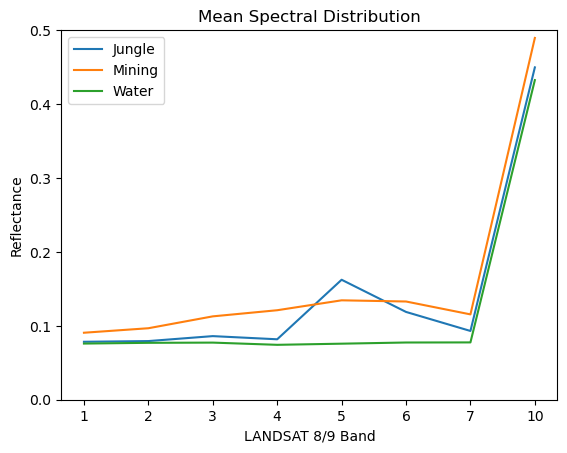

In [110]:


for i in range(len(full_list)):
    if i == 0:
        continue
    plt.plot(np.mean(full_list[i], axis = 0)[0:8]/100000, label = classes[i])
plt.ylim((0,0.5))
plt.title('Mean Spectral Distribution')
plt.xlabel('LANDSAT 8/9 Band')
plt.ylabel('Reflectance')


# Override labels (make sure number of labels matches number of positions)
plt.xticks([0,1,2,3,4,5,6,7], labels=[1,2,3,4,5,6,7,10])
plt.legend()
plt.savefig('output/plots/training_roi_spectral_dist.svg')

In [84]:
### Separatiblity

num_classes = len(full_list)
means = []
covs = []

for c in range(num_classes):
    data = full_list[c]  # shape: (pixels, bands)
    means.append(np.mean(data, axis=0))
    covs.append(np.cov(data, rowvar=False))
    
means = np.array(means)
covs = np.array(covs)

def JM_distance(mean1, cov1, mean2, cov2):
    cov_avg = (cov1 + cov2) / 2
    diff = mean1 - mean2
    term1 = 0.125 * diff.T @ inv(cov_avg) @ diff
    term2 = 0.5 * np.log(det(cov_avg) / np.sqrt(det(cov1) * det(cov2)))
    B = term1 + term2
    JM = 2 * (1 - np.exp(-B))
    return JM

# Calculate JM distances between all pairs
pairs = list(combinations(range(num_classes), 2))
jm_matrix = np.zeros((num_classes, num_classes))

for i, j in pairs:
    jm = JM_distance(means[i], covs[i], means[j], covs[j])
    jm_matrix[i, j] = jm
    jm_matrix[j, i] = jm  # symmetric

pd.DataFrame(jm_matrix, columns=classes,
             index=classes)


,Cloud,Jungle,Mining,Water
Cloud,0.000000,1.993789,1.999895,1.999857
Jungle,1.993789,0.000000,1.997950,1.999989
Mining,1.999895,1.997950,0.000000,1.999936
Water,1.999857,1.999989,1.999936,0.000000


### Accuracy of Classified Land

In [111]:
## TODO:: this section (or just use 'manual inspection'??)

In [18]:
for class_id, class_name in enumerate(classes):
    print(class_id, class_name)
    for img_path, shp_path in roi_sources[class_name]:
        print(class_id, class_name, img_path, shp_path)

0 Cloud
0 Cloud LC08_L2SP_109060_20230506_20230509_02_T1 2023_x4_v2_SHPs/Cloud.shp
1 Jungle
1 Jungle LC08_L2SP_109060_20230506_20230509_02_T1 2023_x4_v2_SHPs/Jungle.shp
1 Jungle LC08_L2SP_109060_20160603_20200907_02_T1 2016_x2_SHPs/Burnt_Jungle.shp
2 Mining
2 Mining LC08_L2SP_109060_20230506_20230509_02_T1 2023_x4_v2_SHPs/Mining.shp
3 Water
3 Water LC08_L2SP_109060_20230506_20230509_02_T1 2023_x4_v2_SHPs/Water.shp
3 Water LC08_L2SP_109060_20190204_20200829_02_T1 2019_x1_SHPs/Ocean.shp
3 Water LC08_L2SP_109060_20160603_20200907_02_T1 2016_x2_SHPs/Ocean.shp
